# Information Extraction from Financial Documents using Topic Modeling

A topic model is usually an unsupervised model that aims at discovering the underlying themes or *topics* in large collections of documents.  

**Main inputs:**

*   Corpus of documents (D)
*   Number of topics (K)

**Main outputs:**

*   Topics or topic indicators (lists of words or distributions of the words in the vocabulary)  
*   Distributions of the topics on the documents

In [1]:
%%capture
!pip install contextualized_topic_models
!pip install contractions
!pip install textblob
!pip install --upgrade ipykernel ipywidgets

In [2]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
import contractions
from textblob import TextBlob
from contextualized_topic_models.models.ctm import ZeroShotTM, CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import torch
import random
from nltk.tokenize import word_tokenize
import warnings 
warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def fix_seeds():
    torch.manual_seed(10)
    torch.cuda.manual_seed(10)
    np.random.seed(10)
    random.seed(10)
    #torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True
    
fix_seeds()

## Loading documents

In [4]:
# Load data
data_path = "/kaggle/input/7-named-entity-recognition/docs-with-entities.csv"
df_docs = pd.read_csv(data_path)

# Convert lists represented as strings to lists within the dataframe
df_docs['HSentences'] = df_docs['HSentences'].apply(ast.literal_eval)
df_docs['MSentences'] = df_docs['MSentences'].apply(ast.literal_eval)

In [5]:
df_docs.head()

,Report Name,Bank Name,Report Date,Page ID,Page Text,MSentences,HSentences,Entity
0,fx_insight_e_16_janvier_2023,citi,16-1-2023,0,\n Citi Global Wealth Investments \n FX Snaps...,[citi global wealth invest fx snapshot major c...,[ Citi Global Wealth Investments FX Snapshot M...,"{'ORG': ['Citi', 'Bloomberg L.P.'], 'GPE': [],..."
1,fx_insight_e_16_janvier_2023,citi,16-1-2023,3,\n Important Disclosure \n “Citi analysts” ref...,[import disclosur citi analyst refer invest pr...,[ Important Disclosure Citi analysts refers to...,"{'ORG': ['CNH', 'CHKL', 'Citibank N.A.', 'CGM'..."
2,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,0,\n Fixed Income \n MUSINGS \n FIXED INCOME Go...,[fix incom muse fix incom goldman sach asset m...,[ Fixed Income MUSINGS FIXED INCOME Goldman Sa...,"{'ORG': ['Feds', 'Goldman Sachs', 'Bloomberg',..."
3,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,1,\n Fixed Income \n MUSINGS \n Goldman Sachs As...,[fix incom muse goldman sach asset manag fix i...,[ Fixed Income MUSINGS Goldman Sachs Asset Man...,"{'ORG': ['Haver Analytics', 'Goldman Sachs Ass..."
4,exemple_analyse_macro_economique_goldman_sachs,goldman_sachs,NaN,2,\n MUSINGS \n FIXED INCOME Goldman Sachs Asse...,[muse fix incom goldman sach asset manag centr...,[ MUSINGS FIXED INCOME Goldman Sachs Asset Man...,"{'ORG': ['Fed Federal', 'Bank', 'Goldman Sachs..."


In [6]:
# Total number of documents 
df_docs.shape

(395, 8)

In [7]:
# Number of documents by org
doc_by_org_counts = df_docs.groupby('Bank Name')['Report Name'].nunique().reset_index()
doc_by_org_counts

,Bank Name,Report Name
0,bnp_parisba,1
1,citi,11
2,goldman_sachs,5
3,jpmorgan,2
4,kkr,1


In [8]:
# Number of total pages by org
pages_by_org_counts = df_docs.groupby('Bank Name')['Page ID'].count().reset_index()
pages_by_org_counts

,Bank Name,Page ID
0,bnp_parisba,30
1,citi,62
2,goldman_sachs,146
3,jpmorgan,85
4,kkr,72


In [9]:
from itertools import chain

def get_document(document, by="words", col="MSentences", paginated=False):
    # Get the sentences of all pages
    pages_sentences = document[col].tolist()   
    
    if by == "words":
        pages_words = []
        for page_sentences in pages_sentences:
            page_words = []
            for sentence in page_sentences:
                sent_tokens = word_tokenize(sentence)
                page_words.append(sent_tokens)
            
            pages_words.append(list(chain.from_iterable(page_words)))
        results = pages_words
        
    elif by == "sentences":
        results = pages_sentences
        
    elif by == "document":
        results = [ " ".join(page_sentences).strip() for page_sentences in pages_sentences ]
        if not paginated: 
            return " ".join(results).strip()
            
    if paginated:
        return results
    return list(chain.from_iterable(results))

## Preprocessing

In [10]:
documents = []

for report in list(df_docs['Report Name'].unique())[:-1]: 
    document = df_docs[df_docs['Report Name'] == report].sort_values(by='Page ID')
    doc_pages = get_document(document, by="document", col="HSentences", paginated=True)
    documents.extend(doc_pages)

print(len(documents))

387


In [11]:
import re
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_multiple_whitespaces
from nltk.corpus import stopwords as stop_words
nltk.download('stopwords')

def replace_symbols(text):
    symbols = {'$': 'dollar','€': 'euro','£': 'pound','¥': 'yen','₹': 'rupee','%': 'percent'}
    for symbol, word in symbols.items():
        text = re.sub(r'(\d)' + re.escape(symbol), r'\1 ' + word, text)
        text = re.sub(re.escape(symbol) + r'(\d)', word + r' \1', text)
        text = re.sub(re.escape(symbol), word, text)
    return text

def remove_urls(text):
    url_pattern_1 = "^https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$"
    url_pattern_2 = r'https?://\S+'
    url_pattern_3 = "^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$"
    url_pattern = f"({url_pattern_1})|({url_pattern_2})|({url_pattern_3})"
    text = re.sub(url_pattern, '', text, flags=re.MULTILINE)
    return text
    
def clean_sent(text):
    text = remove_urls(text)
    text = contractions.fix(text)
    text = re.sub(r'[^\x00-\x7F$€£¥₹]+', '', text)
    text = replace_symbols(text)
    #text = strip_punctuation(text)
    text = remove_stopwords(text)
    #text = re.sub(r'[^a-z0-9\s]', '', text)
    text = strip_multiple_whitespaces(text)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# https://github.com/MilaNLProc/contextualized-topic-models/blob/master/contextualized_topic_models/utils/preprocessing.py
documents = [clean_sent(doc) for doc in documents]
stopwords = list(set(stop_words.words('english'))) + ['percent']
sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords ,vocabulary_size=1500)
preprocessed_documents, unpreprocessed_corpus, vocab, ids = sp.preprocess()

## 1. Topic Modeling with Latent Dirichlet Allocation (LDA)

### Extracting Topics

In [13]:
num_topics = 20

In [14]:
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models import LdaModel 
from gensim.models.coherencemodel import CoherenceModel

split_preprocessed_documents = [word_tokenize(d) for d in preprocessed_documents]
dictionary = Dictionary(split_preprocessed_documents)
corpus = [dictionary.doc2bow(text) for text in split_preprocessed_documents]

lda = LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=500, random_state=42)

In [15]:
def get_topics_lda(topk=10):
    topic_terms = []
    for i in range(num_topics):
        topic_words_list = []
        for word_tuple in lda.get_topic_terms(i, topk):
            topic_words_list.append(dictionary[word_tuple[0]])
        topic_terms.append(topic_words_list)
    return topic_terms

get_topics_lda(5)

[['mths', 'vs', 'nzdusd', 'usdcad', 'audusd'],
 ['us', 'exhibit', 'investment', 'data', 'source'],
 ['index', 'data', 'year', 'dollar', 'growth'],
 ['mths', 'index', 'us', 'investment', 'asset'],
 ['exhibit', 'year', 'recession', 'data', 'us'],
 ['asset', 'dollar', 'management', 'information', 'investment'],
 ['dollar', 'market', 'rates', 'us', 'year'],
 ['investment', 'usd', 'debt', 'securities', 'risk'],
 ['dxy', 'usd', 'mths', 'lt', 'usdcnh'],
 ['inflation', 'exhibit', 'global', 'data', 'investment'],
 ['us', 'investment', 'year', 'growth', 'return'],
 ['year', 'usd', 'exhibit', 'us', 'global'],
 ['mths', 'citi', 'vs', 'lt', 'strategy'],
 ['asset', 'index', 'sachs', 'goldman', 'equity'],
 ['china', 'year', 'exhibit', 'us', 'growth'],
 ['investment', 'us', 'sachs', 'market', 'growth'],
 ['year', 'inflation', 'exhibit', 'energy', 'prices'],
 ['inflation', 'year', 'exhibit', 'cpi', 'core'],
 ['investment', 'securities', 'debt', 'goldman', 'sachs'],
 ['dollar', 'term', 'year', 'global',

### Evaluation
#### Coherence Score
We usually use the topic coherence as main indicator of the quality of the topics. NPMI topic coherence is the most used one and it is computed on the co-occurrences of the words in the original or in an external corpus. The intuition is that if two words often co-occur together, then they are more likely to be related to each other.

In [16]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO

cm = CoherenceModel(model=lda, dictionary=dictionary, 
                    texts=split_preprocessed_documents, coherence='c_npmi')
lda_coherence = cm.get_coherence()  
print("coherence score LDA:", lda_coherence)

coherence score LDA: -0.03209347141033775


#### Diversity of Topics
We can also compute how much diverse are the topics from each other. Ideally we expect topics which represent separate concepts or ideas. In this case, we use the IRBO (inverted ranked biased overlap) measure. Topics with common words at different rankings are penalized less than topics sharing the same words at the highest ranks.

In [17]:
irbo_lda = InvertedRBO(get_topics_lda(10))
print("diversity score LDA:", irbo_lda.score())

diversity score LDA: 0.8166404484843985


### Visualize Topics

In [18]:
%%capture
!pip install pyldavis

#### Dominant Topic and Topic Keywords per Document Paragraph

In [19]:
num_docs = len(documents)

# Get the sentences and their dominant topic
dominant_topics = [max(lda[corpus[i]], key=lambda x: x[1])[0] for i in range(num_docs)]

# Get the top N keywords for each topic
top_n = 10
topic_keywords = lda.show_topics(num_topics=-1, num_words=top_n, formatted=False)

# Create a list of topic keywords for each topic
topic_keywords_list = [", ".join([word for word, _ in topic_keywords[topic_id][1]]) for topic_id in dominant_topics]

# Create a DataFrame
data = {
    "Text": documents,
    "Dominant Topic": [f"Topic {topic_id}" for topic_id in dominant_topics],
    "Topic Keywords": topic_keywords_list
}

df_topic_pages = pd.DataFrame(data)

In [20]:
df_topic_pages.head(20)

,Text,Dominant Topic,Topic Keywords
0,Citi Global Wealth Investments FX Snapshot Maj...,Topic 7,"investment, usd, debt, securities, risk, growt..."
1,Important Disclosure Citi analysts refers inve...,Topic 18,"investment, securities, debt, goldman, sachs, ..."
2,Fixed Income MUSINGS FIXED INCOME Goldman Sach...,Topic 2,"index, data, year, dollar, growth, exhibit, in..."
3,Fixed Income MUSINGS Goldman Sachs Asset Manag...,Topic 13,"asset, index, sachs, goldman, equity, investme..."
4,MUSINGS FIXED INCOME Goldman Sachs Asset Manag...,Topic 11,"year, usd, exhibit, us, global, dollar, source..."
5,MUSINGS FIXED INCOME Goldman Sachs Asset Manag...,Topic 13,"asset, index, sachs, goldman, equity, investme..."
6,MUSINGS FIXED INCOME Goldman Sachs Asset Manag...,Topic 18,"investment, securities, debt, goldman, sachs, ..."
7,MUSINGS FIXED INCOME Goldman Sachs Asset Manag...,Topic 5,"asset, dollar, management, information, invest..."
8,MUSINGS FIXED INCOME Goldman Sachs Asset Manag...,Topic 13,"asset, index, sachs, goldman, equity, investme..."
9,Citi Global Wealth Investments FX Snapshot Maj...,Topic 7,"investment, usd, debt, securities, risk, growt..."


In [21]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
LDAvis_prepared

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.179253 -0.025715       1        1  16.426125
1      0.054265 -0.010956       2        1  14.708681
2      0.061313 -0.036240       3        1   7.734494
11     0.042257 -0.017622       4        1   6.432810
4      0.083732 -0.040357       5        1   5.692231
15    -0.051118 -0.040102       6        1   5.073868
16     0.092083 -0.011154       7        1   4.755844
5     -0.097392 -0.070158       8        1   4.665318
6     -0.031982 -0.019152       9        1   4.346386
14     0.075354 -0.005235      10        1   4.183574
13    -0.130894 -0.035427      11        1   3.618262
10    -0.007135 -0.045917      12        1   3.180596
7     -0.097971 -0.017584      13        1   3.102673
0     -0.005432  0.222630      14        1   2.914695
9      0.017143 -0.041349      15        1   2.836245
3     -0.065460  0.032703      16        1   2.731741
12    -0.010748  0.118512      17        1   2.617549
8      0.013872  0.116612      18        1   2.095207
17     0.116267 -0.038054      19        1   1.809177
19     0.121099 -0.035435      20        1   1.074524, topic_info=           Term        Freq       Total Category  logprob  loglift
17       dollar  385.000000  385.000000  Default  30.0000  30.0000
430   inflation  485.000000  485.000000  Default  29.0000  29.0000
58         year  673.000000  673.000000  Default  28.0000  28.0000
860        mths  146.000000  146.000000  Default  27.0000  27.0000
53          usd  247.000000  247.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
307        rate    8.585022  406.023008  Topic20  -4.4839   0.6769
1002    exhibit    9.172612  646.805946  Topic20  -4.4177   0.2775
424      growth    5.776114  464.283820  Topic20  -4.8802   0.1465
397       asset    5.243554  396.472957  Topic20  -4.9769   0.2077
34       levels    4.702977  190.487670  Topic20  -5.0857   0.8319

[1273 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
607       1  0.585945   act
607       2  0.060097   act
607       4  0.015024   act
607       6  0.075121   act
607       8  0.075121   act
...     ...       ...   ...
954       9  0.049254  zero
954      10  0.073881  zero
954      13  0.024627  zero
954      14  0.049254  zero
954      15  0.049254  zero

[7187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 2, 3, 12, 5, 16, 17, 6, 7, 15, 14, 11, 8, 1, 10, 4, 13, 9, 18, 20])

## 2. Topic Modeling with Zero-shot Contextualized Topic Model

Instead of concatenating the input BoW representation with the contextualized representation, we can just replace it. 
In this way, the model will take as input a representation, try to learn a good topical representation of the documents that allows it to reconstruct the original BoW.

![](https://raw.githubusercontent.com/silviatti/Contextualized-Topic-Models-Tutorial/main/images/zeroshot_ctm.PNG)

In [22]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [23]:
#zero_tp = TopicModelDataPreparation("all-mpnet-base-v2")
#zero_training_dataset = zero_tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

zero_tp = TopicModelDataPreparation('ProsusAI/finbert')
zero_training_dataset = zero_tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/ProsusAI_finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

#### Training Model

In [24]:
zero_ctm = ZeroShotTM(
    bow_size=len(zero_tp.vocab), 
    contextual_size=768,     
    n_components=20, 
    num_epochs=200,         
    dropout=0.1,
    batch_size=8,
    reduce_on_plateau=True,
    lr=2e-3,
    momentum=0.99,
    solver="adam")

zero_ctm.fit(zero_training_dataset) 

Epoch: [200/200]	 Seen Samples: [76800/77400]	Train Loss: 1226.587682088216	Time: 0:00:00.455663: : 200it [01:32,  2.16it/s]
100%|██████████| 49/49 [00:00<00:00, 142.89it/s]


In [25]:
zero_ctm.get_topic_lists(5)

[['usd', 'forecasts', 'aud', 'cad', 'low'],
 ['kkr', 'simple', 'keep', 'macro', 'think'],
 ['management', 'financial', 'asset', 'sachs', 'goldman'],
 ['dollar', 'bps', 'sales', 'day', 'bn'],
 ['fx', 'lt', 'bias', 'vs', 'bullish'],
 ['inflation', 'core', 'haver', 'analytics', 'jul'],
 ['infrastructure', 'sustainable', 'esg', 'focus', 'opportunities'],
 ['policy', 'inflation', 'year', 'expect', 'federal'],
 ['index', 'gs', 'equity', 'market', 'performance'],
 ['seasonally', 'crude', 'ccc', 'composite', 'wti'],
 ['yield', 'equity', 'high', 'bonds', 'group'],
 ['us', 'year', 'december', 'group', 'yields'],
 ['investment', 'securities', 'debt', 'market', 'risk'],
 ['vs', 'mths', 'lt', 'fx', 'bullish'],
 ['portfolio', 'returns', 'return', 'stocks', 'positive'],
 ['debt', 'citigroup', 'grade', 'non', 'rmb'],
 ['cap', 'kkr', 'simple', 'keep', 'think'],
 ['sachs', 'goldman', 'management', 'bank', 'services'],
 ['kkr', 'com', 'macro', 'analysis', 'consumer'],
 ['iran', 'nuclear', 'north', 'macro

### Evaluation
#### Coherence Score

In [26]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI, InvertedRBO
corpus = [word_tokenize(d) for d in preprocessed_documents]
coh = CoherenceNPMI(zero_ctm.get_topic_lists(10), corpus)
print("Coherence Score:", coh.score())

Coherence Score: -0.000933364111608967


#### Diversity of Topics


In [27]:
irbo_zero_ctm = InvertedRBO(zero_ctm.get_topic_lists(10))
print("diversity score:", irbo_zero_ctm.score())

diversity score: 0.9782776754303008


### Visualize Topics

In [28]:
import pyLDAvis as vis

lda_vis_data = zero_ctm.get_ldavis_data_format(zero_tp.vocab, zero_training_dataset, n_samples=20)

zero_ctm_pd = vis.prepare(**lda_vis_data)
vis.display(zero_ctm_pd)

100%|██████████| 49/49 [00:00<00:00, 138.04it/s]


#### WordClouds per Topic

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


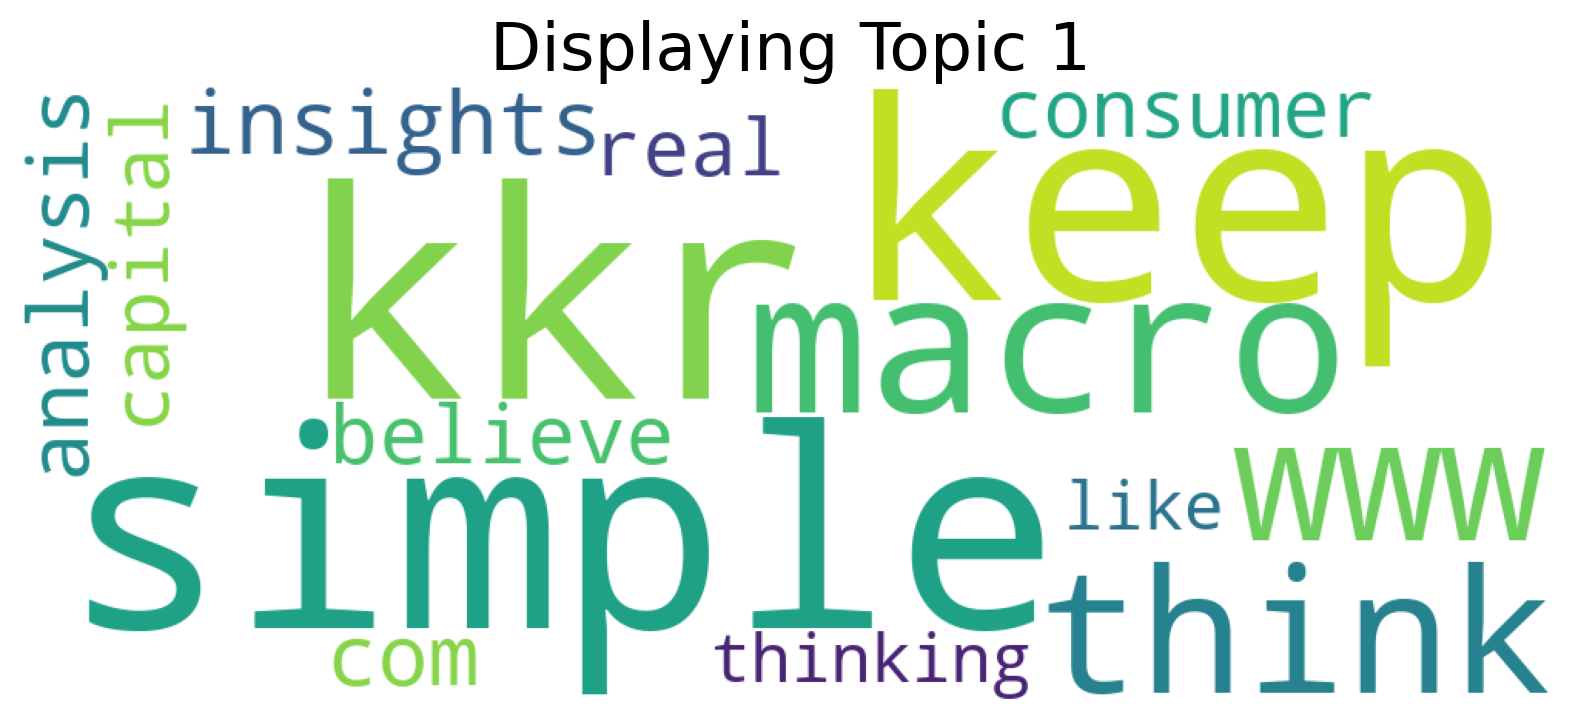

In [29]:
zero_ctm.get_wordcloud(topic_id=1, n_words=15, background_color="white")

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


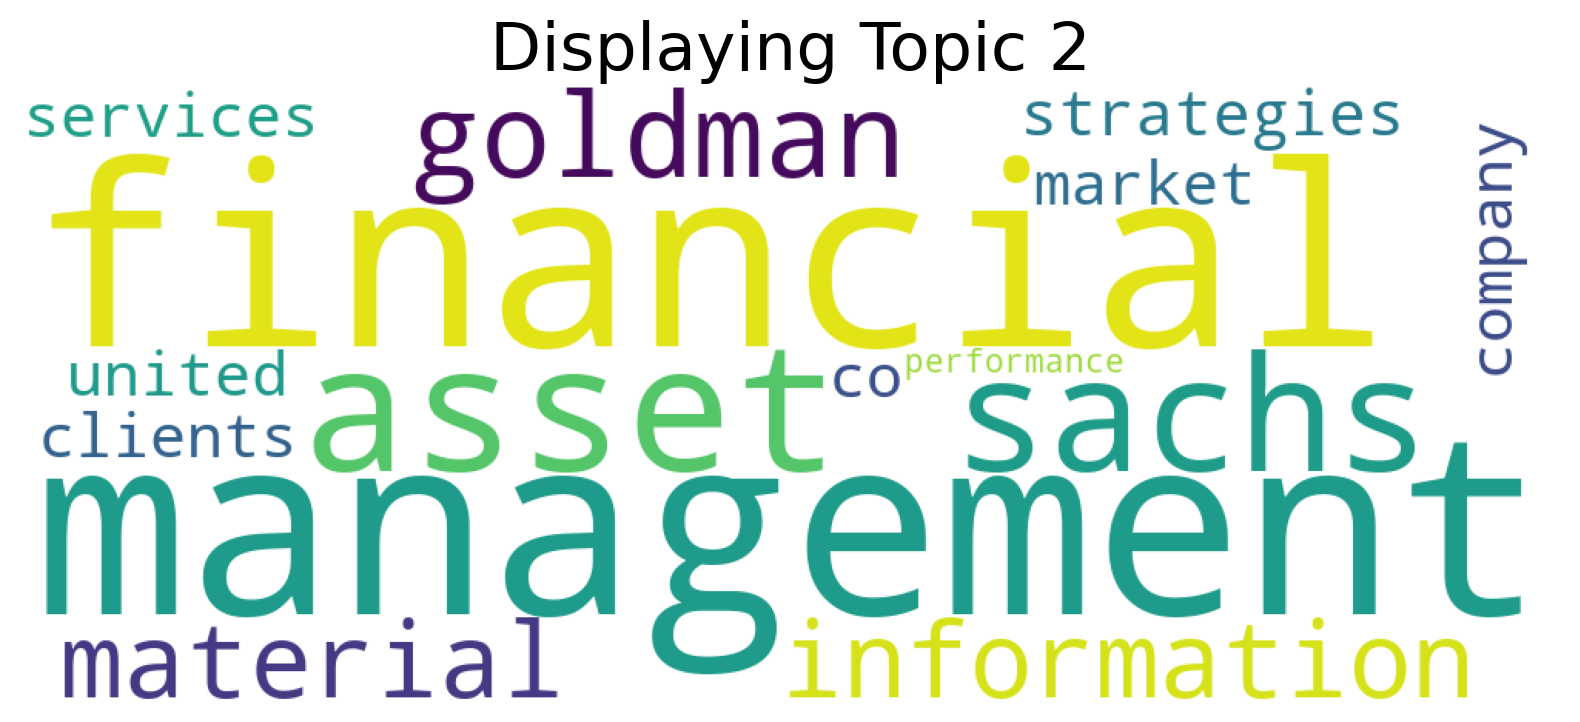

In [30]:
zero_ctm.get_wordcloud(topic_id=2, n_words=15, background_color="white")

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


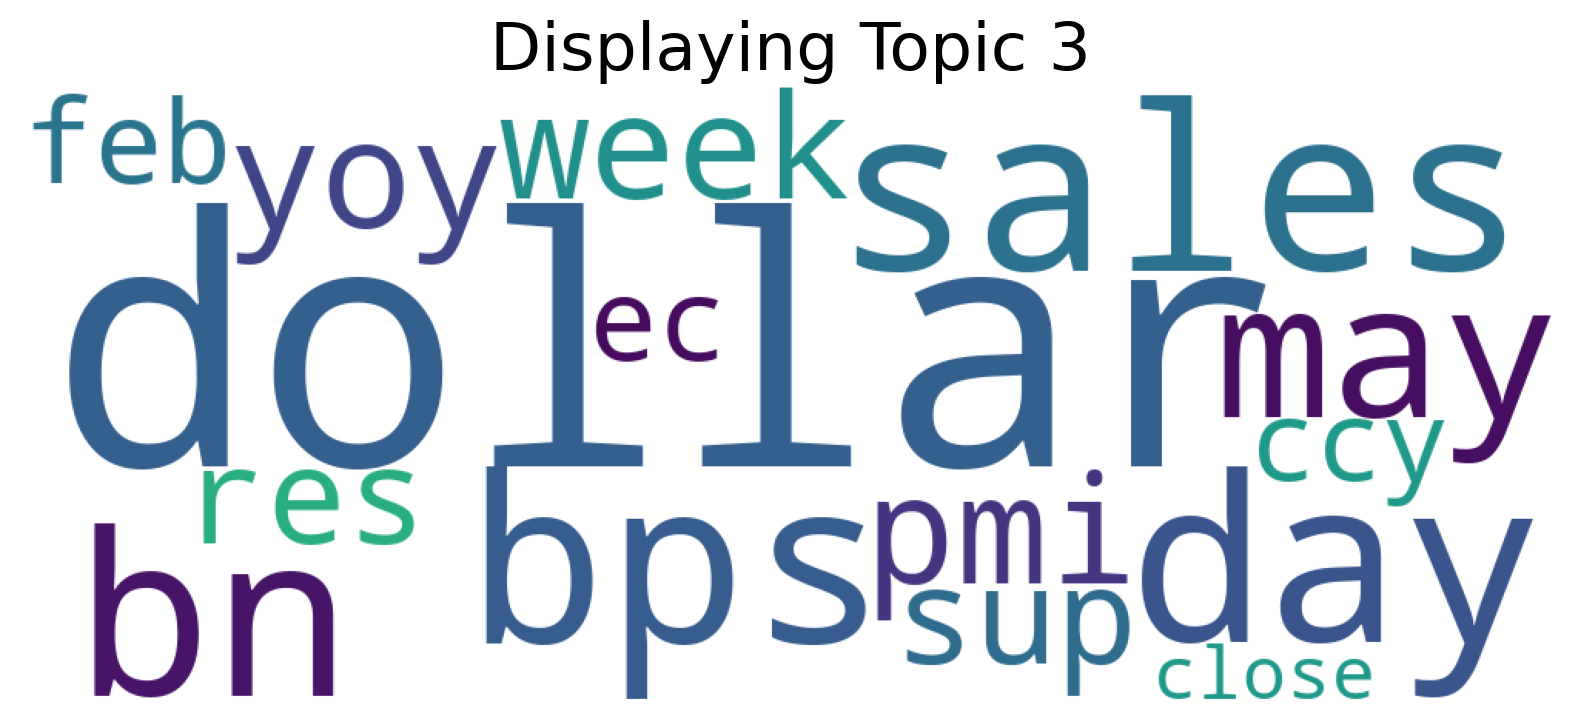

In [31]:
zero_ctm.get_wordcloud(topic_id=3, n_words=15, background_color="white")

#### Dominant Topic per Paragraph

In [32]:
doc_id = 107
unpreprocessed_corpus[doc_id]

'58 Goldman Sachs january 2023 As case 2022, interplays inflation, Federal Reserve policy economic growth remain key macroeconomic influences year ahead. The Eurozone: About-Face Russias invasion Ukraine caused abrupt decline Eurozones expected growth year. Not resulting surge energy prices sharp drop real household disposable income (see Exhibit 97), forced production cutbacks energy-intensive industries, hurt output. Although fiscal support helped mitigate economic impact spiraling energy prices, central bank policy eroded cushion ECB accelerated hiking cycle contain record-high inflation (see Exhibit 98). While economy held better feared, think combination headwinds likely pushed Eurozone recession final months 2022. We expect relatively shallow economic contraction barring colder normal winter, peak-to-trough real GDP decline 0.8 percent, recovery likely sluggish. Several headwindsincluding weak external demand, elevated energy prices tight financial conditionsare set constrain gro

In [33]:
topics_predictions = zero_ctm.training_doc_topic_distributions 
topic_id = np.argmax(topics_predictions[doc_id]) 

In [34]:
zero_ctm.get_topic_lists(10)[topic_id]

['policy',
 'inflation',
 'year',
 'expect',
 'federal',
 'growth',
 'rate',
 'recession',
 'exhibit',
 'reserve']

#### Top K Paragraphs per Topic

In [35]:
topic_id = 15
top_k = 3
print(zero_ctm.get_topics()[topic_id])
top_documents = zero_ctm.get_top_documents_per_topic_id(unpreprocessed_corpus, topics_predictions, topic_id, k=top_k)
top_documents

['debt', 'citigroup', 'grade', 'non', 'rmb', 'risk', 'credit', 'investor', 'unrated', 'exchange']


[("Important Disclosure Citi analysts refers investment professionals Citi Research (CR) Citi Global Markets (CGM) voting members Global Investment Committee Global Wealth Management. Citibank N.A. affiliates / subsidiaries provide independent research analysis substance preparation document. Investment products available US persons products services provided affiliates available locations. This document general informational purposes intended recommendation offer solicitation purchase sale security, currency, investment, service attract funds deposits. Save extent provided Terms Conditions Accounts Services applicable terms conditions, information document prepared taking account objectives, financial situation needs particular investor. Therefore, investment products mentioned document suitable investors. Any person considering investment seek independent advice suitability particular investment. Before making investment, investor obtain investment offering materials, include descrip

#### Predict Topics on Unseen Document

In [36]:
unseen_report = list(df_docs['Report Name'].unique())[-1]
print(unseen_report)
document = df_docs[df_docs['Report Name'] == unseen_report].sort_values(by='Page ID')
unseen_doc = get_document(document, by="document", col="HSentences", paginated=True)

fx_insight_e


In [37]:
testing_dataset = zero_tp.transform(unseen_doc) 

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/ProsusAI_finbert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
# n_sample how many times to sample the distribution 
test_topics_predictions = zero_ctm.get_thetas(testing_dataset, n_samples=10) # get all the topic predictions

100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


In [39]:
# Paragraph / Page ID
test_document_index=4
unseen_doc[test_document_index]

'European Currencies GBP Citi views & strategy Bias/ Forecasts/ Key levels Citi FX outlook The MPC is likely to pause after a 25bp hike in June until November after which there it could shift towards cuts. This is earlier than what OIS rates are pricing and represents a medium-term headwind for sterling. The medium to longer term view does not get any better for GBP from UKs external vulnerabilities. Previously GBPUSD: 0 3mths: 1.27 GBPUSD: 6 12mths: 1.27 GBPUSD: LT: 1.40 Currently (as of May): GBPUSD: 0 3mth: 1.26 GBPUSD: 6 12mth: 1.27 GBPUSD: LT: 1.40 6-12mths: Moderately bullish GBP vs USD, bearish vs EUR EUR Citi views & strategy Bias/ Forecasts/ Key levels Citi FX outlook A break above 1.1100 1.1200 resistance looks likely over the medium term as several dynamics favor EURUSD upside (1) a resilient euro area banking system vs US; (2) euro areas relative growth resilience vs US in part, due to Chinas recovery admittedly under some question marks lately but momentum is likely to pic

In [40]:
# Get topic
topic_number = np.argmax(test_topics_predictions[test_document_index]) 
zero_ctm.get_topic_lists(10)[topic_number] 
print('- Paragraph', test_document_index, 'is mostly likely to be talking about topic', topic_number)
print('- Topic',topic_number,'Keywords :')
print(zero_ctm.get_topic_lists(10)[topic_number])

- Paragraph 4 is mostly likely to be talking about topic 4
- Topic 4 Keywords :
['fx', 'lt', 'bias', 'vs', 'bullish', 'previously', 'mths', 'bearish', 'nzdusd', 'mth']


#### Save Model

- https://github.com/MilaNLProc/contextualized-topic-models/blob/master/contextualized_topic_models/models/ctm.py

#### References
- https://github.com/MilaNLProc/contextualized-topic-models/tree/master
- https://colab.research.google.com/drive/1EO0bS0Wow_cjdGsDfV38xt--AxJQjFtg?usp=sharing#scrollTo=71CWic5ZWxJg
- https://www.sbert.net/docs/pretrained_models.html
-https://nlp-css-201-tutorials.github.io/nlp-css-201-tutorials/ 
- https://www.youtube.com/@nlpandcss201beyondthebasic6/videos
- https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/
- https://towardsdatascience.com/topic-modelling-into-a-category-tree-acafad0f0050
- https://anotherreeshu.wordpress.com/2020/06/11/topic-modelling-latent-dirichlet-allocation-an-introduction/
- https://contextualized-topic-models.readthedocs.io/_/downloads/en/latest/pdf/
- https://towardsdatascience.com/contextualized-topic-modeling-with-python-eacl2021-eacf6dfa576